In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import torch
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, PercentFormatter


import json
import os
import pickle
from pathlib import Path
import optuna
import wandb

os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"

In [2]:
params = {
    "pgf.texsystem": "xelatex",
    "pgf.rcfonts": False,
    "font.serif": [],
    "font.family": "serif",
    "font.sans-serif": [],
    "axes.labelsize": 11,
}

plt.rcParams.update(params)
rc("text", usetex=True)

plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage[utf8]{inputenc}')

CM = 1 / 2.54
# cmap = plt.cm.get_cmap("viridis")
cmap = mpl.colormaps.get_cmap("plasma")
# plt.style.use(['science','nature'])

# Bright color scheme
# color-blind safe
# from Paul Tot's website: https://personal.sron.nl/~pault/
# Set color cycle
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', ['4477AA', 'EE6677', '228833', 'CCBB44', '66CCEE', 'AA3377', 'BBBBBB'])


# Standard SciencePlots color cycle
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(
    "color", ["0C5DA5", "00B945", "FF9500", "FF2C00", "845B97", "474747", "9e9e9e"]
)


## Comparsion of Accuracies

In [ ]:
plt.figure(figsize=(8*CM,8*CM))  
    
# plot orientation line
x = np.linspace(0, 10, num=100)
y = np.linspace(0, 10, num=100)
plt.plot(x,y,'--', c="black", linewidth=0.5)
    
# Preparing dataset
x = [x for x in range(10)]
y = [5, 2, 4, 8, 5, 6, 8, 7, 1, 3]
text = ["first", "second", "third", "fourth", "fifth",
        "sixth", "seventh", "eighth", "ninth", "tenth"]

# plotting scatter plot
plt.scatter(x, y, zorder=10)
  
# Loop for annotation of all points
for i in range(len(x)):
    plt.annotate(text[i], (x[i]-0.8, y[i] + 0.4))


# adjusting the scale of the axes
plt.xlim((0, 10))
plt.ylim((0, 10))

plt.ylabel("Validation Accuracy")
plt.xlabel("Training Accuracy")

plt.tight_layout()
# plt.show()
plt.savefig("../reports/Graphs/training-validation-accuracy.pdf", bbox_inches="tight")

## Cross-Entropy Loss

In [ ]:
# 100 linearly spaced numbers
x = np.linspace(-2,2,100)
# the function, which is y = x^2 here
y = np.log(1 + np.exp(-2*x))

# setting the axes at the centre
fig = plt.figure(figsize=(12 * CM, 6 * CM))
ax = fig.add_subplot(1, 1, 1)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xlabel("Margin $y-F_m(\mathbf{x})$")
ax.set_ylabel("Loss")

# plot the function
plt.plot(x,y, label="cross-entropy loss")
plt.legend(frameon=False)
plt.savefig("../reports/Graphs/cross-entropy-loss.pdf", bbox_inches="tight")
# show the p

## Histogram Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.6 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=1)
# regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
# regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
# y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure(figsize=(8*CM,6*CM))
plt.scatter(X, y, s=20, c="yellowgreen", edgecolors="black", linewidth=0.5, label="Data")
plt.plot(X_test, y_1, color="cornflowerblue", label="Approximation", linewidth=1)
# plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.legend(frameon=False)
plt.tight_layout()
# plt.show()

plt.savefig("../reports/Graphs/dt-decision-boundary.pdf", bbox_inches="tight")

## Train-Test Split

In [ ]:
def to_mpl(start: str, end: str):
    mpl_start = mdates.date2num(pd.to_datetime(start))
    mpl_end = mdates.date2num(pd.to_datetime(end))
    return mpl_start, mpl_end - mpl_start


In [ ]:
def to_pos(span: tuple):
    return span[0] + 0.5 * span[1]


In [ ]:
fig, (ax, bx) = plt.subplots(
    2, 1, sharey="none", sharex="col", figsize=(12 * CM, 6 * CM)
)

# ise
ax.broken_barh([to_mpl("2005-05-02", "2017-05-31")], (1, 5), facecolors="lightgray")

# ise pretraining
span = [to_mpl("2012-10-23", "2013-10-24")]
ax.broken_barh(span, (2.5, 1), facecolors=(168/255,209/255,238/255), edgecolor="black", linewidth=0.8)

ax.text(
    x=to_pos(span[0]),
    y=3,
    s="train",
    ha="center",
    va="center",
    color="black",
    fontsize="small",
)

spans = [
    to_mpl("2005-05-02", "2013-10-24"),
    to_mpl("2013-10-25", "2015-11-05"),
    to_mpl("2015-11-06", "2017-05-31"),
]

# ise supervised
ax.broken_barh(
    spans,
    (1.2, 1),
    facecolors=((168/255,209/255,238/255), (204/255,212/255,151/255), (239/255,171/255,170/255)),
    edgecolor="black",
    linewidth=0.8,
)

# add text labels manually
labels = ["train", "val", "test"]
for i, s in enumerate(spans):
    ax.text(
        x=to_pos(s),
        y=1.7,
        s=labels[i],
        ha="center",
        va="center",
        color="black",
        fontsize="small",
    )

ax.xaxis_date()
plt.setp(ax.get_xticklabels(), visible=True)

# cboe
bx.broken_barh([to_mpl("2011-01-01", "2017-10-31")], (1, 3), facecolors="lightgray")

spans = [
    to_mpl("2015-11-06", "2017-10-31"),
]

# cboe supervised
bx.broken_barh(
    spans,
    (1.85, 1),
    facecolors=(239/255,171/255,170/255),
    edgecolor="black",
    linewidth=0.8,
)

# add text labels manually
labels = ["test"]
for i, s in enumerate(spans):
    bx.text(
        x=to_pos(s),
        y=2.35,
        s=labels[i],
        ha="center",
        va="center",
        color="black",
        fontsize="small",
    )



# Modify y-axis tick labels
ax.set_yticks([1.7, 3], labels=["ISE\n Supervised", "ISE\n Pretraining"])
bx.set_yticks([2.35], labels=["CBOE"])

ax.set_ylim(1, 3.7)
bx.set_ylim(1, 3.7)

# into to date
bx.xaxis_date()

plt.xlabel("Date")

# plt.show()
plt.savefig("../reports/Graphs/train-test-split.pdf", bbox_inches="tight")


## Attention

In [ ]:
# code from https://d2l.ai/d2l-en.pdf
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap=cmap):
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = plt.subplots(
        num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False
    )
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes)
    plt.savefig("../reports/Graphs/attention-maps.pdf", bbox_inches="tight")


In [ ]:
# attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
attention_weights = torch.rand(size=(2, 4, 10, 10))
show_heatmaps(
    attention_weights, xlabel="Keys", ylabel="Queries", figsize=(12 * CM, 6 * CM)
)


In [ ]:
# Code from https://www.tensorflow.org/tutorials/text/transformer
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return pos_encoding


In [ ]:
tokens = 64
dimensions = 96


pos_encoding = positional_encoding(tokens, dimensions)
print(pos_encoding.shape)

plt.figure(figsize=(12 * CM, 6 * CM))
plt.pcolormesh(pos_encoding[0], cmap=cmap)
plt.xlabel("Embedding dimension $d_e$")
plt.xlim((0, dimensions))
plt.ylim((tokens, 0))
plt.ylabel("token position $t$")
plt.colorbar()
plt.savefig("../reports/Graphs/positional-encoding.pdf", bbox_inches="tight")


## Semi-Supervised Decision Boundary

In [ ]:
# Authors: Clay Woolam   <clay@woolam.org>
#          Oliver Rausch <rauscho@ethz.ch>
# License: BSD

# import numpy as np
# import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import SelfTrainingClassifier

from matplotlib.ticker import MaxNLocator # needed for integer only on axis
from matplotlib.lines import Line2D # for creating the custom legend

iris = datasets.load_iris()

X = iris.data[:, :2]
y = iris.target

# mask = y[y<2]

# y = y[-mask]
# X = X[-mask]

# print(mask.astype(bool))

# step size in the mesh
h = 0.1

rng = np.random.RandomState(0)
y_rand = rng.rand(y.shape[0])
y_30 = np.copy(y)
y_30[y_rand < 0.3] = -1  # set random samples to be unlabeled
y_50 = np.copy(y)
y_50[y_rand < 0.5] = -1
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
# ls30 = (LabelSpreading().fit(X, y_30), y_30, "Label Spreading 30% data")
# ls50 = (LabelSpreading().fit(X, y_50), y_50, "Label Spreading 50% data")
# ls100 = (LabelSpreading().fit(X, y), y, "Label Spreading 100% data")

# the base classifier for self-training is identical to the SVC
base_classifier = SVC(kernel="rbf", gamma=0.5, probability=True)
st30 = (
    SelfTrainingClassifier(base_classifier).fit(X, y_30),
    y_30,
    "Semi-Supervised Classifier",
)
# st50 = (
#     SelfTrainingClassifier(base_classifier).fit(X, y_50),
#     y_50,
#     "Self-training 50% data",
# )

rbf_svc = (base_classifier.fit(X, y), y, "Supervised Classifier")

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

PROB_DOT_SCALE = 40 # modifier to scale the probability dots
PROB_DOT_SCALE_POWER = 3 # exponential used to increase/decrease size of prob dots
TRUE_DOT_SIZE = 50 #

redish = '#d73027'
orangeish = '#fc8d59'
yellowish = '#fee090'
blueish = '#4575b4'
colormap = np.array([redish,blueish,orangeish])

color_map = {-1: (1, 1, 1), 0: (0, 0, 0.9), 1: (1, 0, 0), 2: (0.8, 0.6, 0)}

ax = plt.figure(figsize=(12*CM, 6*CM))

classifiers = (rbf_svc, st30)
for i, (clf, y_train, title) in enumerate(classifiers):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(1, 2, i+1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    z_proba =  clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # the size of each probability dot
    Z_size = np.max(Z_proba, axis=1) 
    
    Z = Z.reshape(xx.shape)
    
    tri = plt.tricontourf(xx.flatten(), yy.flatten(), z_proba[:,1], levels=14, cmap="RdBu_r")
    plt.contour(xx, yy, z_proba[:,1].reshape(xx.shape), 15, linewidths=0.5, colors="k")
    
    
    # Plot also the training points
    colors = [color_map[y] for y in y_train]

    
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=20, edgecolors="black", linewidth=0.5, zorder=10)

    plt.title(title, y=-0.3)

plt.savefig("../reports/Graphs/semi-supervised-decision-boundary.pdf", bbox_inches="tight")
# plt.suptitle("Unlabeled points are colored white", y=0.1)
plt.show()

## Hyperparameter Search Space

In [35]:
# set study globally here
# study = "1gzk7msy.optuna:v49" # gbm classical
# study = "3vntumoi.optuna:v49" # gbm classical-size
# study = "2t5zo50f.optuna:v49" # gbm ml

# study = "37lymmzc.optuna:v49" # gbm semi-classical
# study = "1vmti6db.optuna:v49" # gbm semi classical-size
# study = "t55nd8r0.optuna:v49" # gbm semi ml

# transformer 
# study = "3jpe46s1.optuna:v9" # transformer classical
# study = "1qx3ul4j.optuna:v9" # transformer classical-size
study = "2h81aiow.optuna:v9" # transformer ml

In [36]:
# see https://wandb.ai/fbv/thesis/runs/kwlaw02g/overview?workspace=user-karelze
run = wandb.init(project="thesis", entity="fbv")

# model_name = model.split("/")[-1].split(":")[0]
# study_id = model_name.split("_")[0]

study_id = study.split(".")[0]


artifact = run.use_artifact(study)
study_dir = artifact.download()

# artifact = run.use_artifact(model)
# model_dir = artifact.download()

study_name, version = study.split(":")

/pfs/data5/home/kit/stud/uloak/thesis/thesis/lib64/python3.9/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
wandb:   2 of 2 files downloaded.  


In [37]:
file  = open(f"./artifacts/{study_id}.optuna:{version}/{study_id}.optuna",'rb')
study = pickle.load(file)

sampler = study.sampler
storage = f"sqlite:///artifacts/{study_id}.optuna:{version}/{study_id}.db"

study = optuna.load_study(study_name=study_id, storage=storage, sampler=sampler)

In [38]:
LUT_LABELS = {"Objective Value": "Accuracy", "bagging_temperature": "Bagging Temp.", "depth":"Depth", "l2_leaf_reg": "$\ell_2$ Leaf Reg." , "learning_rate" : "$\eta$", "random_strength": "Rand. Str.", "attention_dropout": "Att Dropout", "d_token":"$d_e$","ffn_dropout":"FFN Dropout", "weight_decay":"$\lambda$","lr": "$\eta$","n_blocks":"$L$"}

In [39]:
from typing import Callable
from typing import Dict
from typing import List
from typing import Optional
from typing import Sequence
from typing import Tuple
from typing import Union

import numpy as np

from optuna._experimental import experimental_func
from optuna._imports import try_import
from optuna.logging import get_logger
from optuna.study import Study
from optuna.trial import FrozenTrial
from optuna.visualization._contour import _AxisInfo
from optuna.visualization._contour import _ContourInfo
from optuna.visualization._contour import _get_contour_info
from optuna.visualization._contour import _SubContourInfo
from optuna.visualization.matplotlib._matplotlib_imports import _imports


with try_import() as _optuna_imports:
    import scipy

if _imports.is_successful():
    from optuna.visualization.matplotlib._matplotlib_imports import Axes
    from optuna.visualization.matplotlib._matplotlib_imports import Colormap
    from optuna.visualization.matplotlib._matplotlib_imports import ContourSet
    from optuna.visualization.matplotlib._matplotlib_imports import plt

_logger = get_logger(__name__)


CONTOUR_POINT_NUM = 100


def plot_contour(
    study: Study,
    params: Optional[List[str]] = None,
    *,
    target: Optional[Callable[[FrozenTrial], float]] = None,
    target_name: str = "Objective Value",
) -> "Axes":
    """Plot the parameter relationship as contour plot in a study with Matplotlib.

    Note that, if a parameter contains missing values, a trial with missing values is not plotted.

    .. seealso::
        Please refer to :func:`optuna.visualization.plot_contour` for an example.

    Warnings:
        Output figures of this Matplotlib-based
        :func:`~optuna.visualization.matplotlib.plot_contour` function would be different from
        those of the Plotly-based :func:`~optuna.visualization.plot_contour`.

    Example:

        The following code snippet shows how to plot the parameter relationship as contour plot.

        .. plot::

            import optuna


            def objective(trial):
                x = trial.suggest_float("x", -100, 100)
                y = trial.suggest_categorical("y", [-1, 0, 1])
                return x ** 2 + y


            sampler = optuna.samplers.TPESampler(seed=10)
            study = optuna.create_study(sampler=sampler)
            study.optimize(objective, n_trials=30)

            optuna.visualization.matplotlib.plot_contour(study, params=["x", "y"])

    Args:
        study:
            A :class:`~optuna.study.Study` object whose trials are plotted for their target values.
        params:
            Parameter list to visualize. The default is all parameters.
        target:
            A function to specify the value to display. If it is :obj:`None` and ``study`` is being
            used for single-objective optimization, the objective values are plotted.

            .. note::
                Specify this argument if ``study`` is being used for multi-objective optimization.
        target_name:
            Target's name to display on the color bar.

    Returns:
        A :class:`matplotlib.axes.Axes` object.

    .. note::
        The colormap is reversed when the ``target`` argument isn't :obj:`None` or ``direction``
        of :class:`~optuna.study.Study` is ``minimize``.
    """

    _imports.check()
    info = _get_contour_info(study, params, target, target_name)
    return _get_contour_plot(info)



def _get_contour_plot(info: _ContourInfo) -> "Axes":

    sorted_params = info.sorted_params
    sub_plot_infos = info.sub_plot_infos
    reverse_scale = info.reverse_scale
    target_name = info.target_name

    if len(sorted_params) <= 1:
        _, ax = plt.subplots()
        return ax
    n_params = len(sorted_params)

    if n_params == 2:
        # Set up the graph style.
        fig, axs = plt.subplots()
        cmap = _set_cmap(reverse_scale)

        cs = _generate_contour_subplot(sub_plot_infos[0][0], axs, cmap)
        if isinstance(cs, ContourSet):
            axcb = fig.colorbar(cs)
            axcb.set_label("Accuracy")
    else:
        # Set up the graph style.
        fig, axs = plt.subplots(n_params, n_params, figsize=(15 *CM, 15 *CM))
        cmap = _set_cmap(reverse_scale)

        # Prepare data and draw contour plots.
        cs_list = []
        for x_i in range(len(sorted_params)):
            for y_i in range(len(sorted_params)):
                ax = axs[y_i, x_i]
                cs = _generate_contour_subplot(sub_plot_infos[y_i][x_i], ax, cmap)
                if isinstance(cs, ContourSet):
                    cs_list.append(cs)
        if cs_list:
            axcb = fig.colorbar(cs_list[0], ax=axs, aspect=50)
            axcb.set_label("Accuracy")

    return axs


def _set_cmap(reverse_scale: bool) -> "Colormap":
    cmap = "Blues_r" if not reverse_scale else "Blues"
    return plt.get_cmap(cmap)


class _LabelEncoder:
    def __init__(self) -> None:
        self.labels: List[str] = []

    def fit(self, labels: List[str]) -> "_LabelEncoder":
        self.labels = sorted(set(labels))
        return self

    def transform(self, labels: List[str]) -> List[int]:
        return [self.labels.index(label) for label in labels]

    def fit_transform(self, labels: List[str]) -> List[int]:
        return self.fit(labels).transform(labels)

    def get_labels(self) -> List[str]:
        return self.labels

    def get_indices(self) -> List[int]:
        return list(range(len(self.labels)))


def _calculate_griddata(
    xaxis: _AxisInfo,
    yaxis: _AxisInfo,
    z_values_dict: Dict[Tuple[int, int], float],
) -> Tuple[
    np.ndarray,
    np.ndarray,
    np.ndarray,
    List[int],
    List[str],
    List[int],
    List[str],
    List[Union[int, float]],
    List[Union[int, float]],
    List[Union[int, float]],
]:

    x_values = []
    y_values = []
    z_values = []
    for x_value, y_value in zip(xaxis.values, yaxis.values):
        if x_value is not None and y_value is not None:
            x_values.append(x_value)
            y_values.append(y_value)
            x_i = xaxis.indices.index(x_value)
            y_i = yaxis.indices.index(y_value)
            z_values.append(z_values_dict[(x_i, y_i)])

    # Return empty values when x or y has no value.
    if len(x_values) == 0 or len(y_values) == 0:
        return np.array([]), np.array([]), np.array([]), [], [], [], [], [], []

    def _calculate_axis_data(
        axis: _AxisInfo,
        values: Sequence[Union[str, float]],
    ) -> Tuple[np.ndarray, List[str], List[int], List[Union[int, float]]]:

        # Convert categorical values to int.
        cat_param_labels = []  # type: List[str]
        cat_param_pos = []  # type: List[int]
        returned_values: Sequence[Union[int, float]]
        if axis.is_cat:
            enc = _LabelEncoder()
            returned_values = enc.fit_transform(list(map(str, values)))
            cat_param_labels = enc.get_labels()
            cat_param_pos = enc.get_indices()
        else:
            returned_values = list(map(lambda x: float(x), values))

        # For x and y, create 1-D array of evenly spaced coordinates on linear or log scale.
        if axis.is_log:
            ci = np.logspace(np.log10(axis.range[0]), np.log10(axis.range[1]), CONTOUR_POINT_NUM)
        else:
            ci = np.linspace(axis.range[0], axis.range[1], CONTOUR_POINT_NUM)

        return ci, cat_param_labels, cat_param_pos, list(returned_values)

    xi, cat_param_labels_x, cat_param_pos_x, transformed_x_values = _calculate_axis_data(
        xaxis,
        x_values,
    )
    yi, cat_param_labels_y, cat_param_pos_y, transformed_y_values = _calculate_axis_data(
        yaxis,
        y_values,
    )

    # Calculate grid data points.
    zi: np.ndarray = np.array([])
    # Create irregularly spaced map of trial values
    # and interpolate it with Plotly's interpolation formulation.
    if xaxis.name != yaxis.name:
        zmap = _create_zmap(transformed_x_values, transformed_y_values, z_values, xi, yi)
        zi = _interpolate_zmap(zmap, CONTOUR_POINT_NUM)

    return (
        xi,
        yi,
        zi,
        cat_param_pos_x,
        cat_param_labels_x,
        cat_param_pos_y,
        cat_param_labels_y,
        transformed_x_values,
        transformed_y_values,
        z_values,
    )


def _generate_contour_subplot(info: _SubContourInfo, ax: "Axes", cmap: "Colormap") -> "ContourSet":

    if len(info.xaxis.indices) < 2 or len(info.yaxis.indices) < 2:
        ax.label_outer()
        return ax

    # replace with lut values
    # ax.set(xlabel=info.xaxis.name, ylabel=info.yaxis.name)
    ax.set(xlabel=LUT_LABELS[info.xaxis.name], ylabel=LUT_LABELS[info.yaxis.name])
    ax.set_xlim(info.xaxis.range[0], info.xaxis.range[1])
    ax.set_ylim(info.yaxis.range[0], info.yaxis.range[1])

    ax.tick_params(axis='both', which='major', labelsize="small")
    # ax.tick_params(axis='both', which='minor', labelsize="x-small")
    
    if info.xaxis.name == info.yaxis.name:
        ax.label_outer()
        return ax

    (
        xi,
        yi,
        zi,
        x_cat_param_pos,
        x_cat_param_label,
        y_cat_param_pos,
        y_cat_param_label,
        x_values,
        y_values,
        z_values,
    ) = _calculate_griddata(info.xaxis, info.yaxis, info.z_values)
    
    # https://stackoverflow.com/a/55929839/5755604
    max_value = max(z_values)
    order = np.argsort(z_values)
#             print(order)
#             print(np.take(x_values, order))
            
#             print(np.arrange(x_values[order]))
            
    colors = ['black' if z < max_value else 'white' for z in z_values]
            # marker = ["o" if z != max_value else "x" for z in z_values]
    x_values = np.take(x_values, order)
    y_values = np.take(y_values, order)
    colors = np.take(colors, order)
    
    # print(x_values)
    
    cs = None
    if len(zi) > 0:
        if info.xaxis.is_log:
            ax.set_xscale("log")
            ax.tick_params(axis='x', which='major', labelsize="xx-small")
        if info.yaxis.is_log:
            ax.set_yscale("log")
            ax.tick_params(axis='y', which='major', labelsize="xx-small")
        if info.xaxis.name != info.yaxis.name:
            # Contour the gridded data.
            ax.contour(xi, yi, zi, 15, linewidths=0.5, colors="k")
            cs = ax.contourf(xi, yi, zi, 15, cmap=cmap.reversed())
            # Plot data points.

            ax.scatter(
                x_values,
                y_values,
                marker="o",
                c=colors,
                s=10,
                edgecolors="grey",
                linewidth=0.5,
            )
    if info.xaxis.is_cat:
        ax.set_xticks(x_cat_param_pos)
        ax.set_xticklabels(x_cat_param_label)
    if info.yaxis.is_cat:
        ax.set_yticks(y_cat_param_pos)
        ax.set_yticklabels(y_cat_param_label)
    ax.label_outer()
    return cs


def _create_zmap(
    x_values: List[Union[int, float]],
    y_values: List[Union[int, float]],
    z_values: List[float],
    xi: np.ndarray,
    yi: np.ndarray,
) -> Dict[Tuple[int, int], float]:

    # Creates z-map from trial values and params.
    # z-map is represented by hashmap of coordinate and trial value pairs.
    #
    # Coordinates are represented by tuple of integers, where the first item
    # indicates x-axis index and the second item indicates y-axis index
    # and refer to a position of trial value on irregular param grid.
    #
    # Since params were resampled either with linspace or logspace
    # original params might not be on the x and y axes anymore
    # so we are going with close approximations of trial value positions.
    zmap = dict()
    for x, y, z in zip(x_values, y_values, z_values):
        xindex = int(np.argmin(np.abs(xi - x)))
        yindex = int(np.argmin(np.abs(yi - y)))
        zmap[(xindex, yindex)] = z

    return zmap


def _interpolate_zmap(zmap: Dict[Tuple[int, int], float], contour_plot_num: int) -> np.ndarray:

    # Implements interpolation formulation used in Plotly
    # to interpolate heatmaps and contour plots
    # https://github.com/plotly/plotly.js/blob/95b3bd1bb19d8dc226627442f8f66bce9576def8/src/traces/heatmap/interp2d.js#L15-L20
    # citing their doc:
    #
    # > Fill in missing data from a 2D array using an iterative
    # > poisson equation solver with zero-derivative BC at edges.
    # > Amazingly, this just amounts to repeatedly averaging all the existing
    # > nearest neighbors
    #
    # Plotly's algorithm is equivalent to solve the following linear simultaneous equation.
    # It is discretization form of the Poisson equation.
    #
    #     z[x, y] = zmap[(x, y)]                                  (if zmap[(x, y)] is given)
    # 4 * z[x, y] = z[x-1, y] + z[x+1, y] + z[x, y-1] + z[x, y+1] (if zmap[(x, y)] is not given)

    a_data = []
    a_row = []
    a_col = []
    b = np.zeros(contour_plot_num**2)
    for x in range(contour_plot_num):
        for y in range(contour_plot_num):
            grid_index = y * contour_plot_num + x
            if (x, y) in zmap:
                a_data.append(1)
                a_row.append(grid_index)
                a_col.append(grid_index)
                b[grid_index] = zmap[(x, y)]
            else:
                for dx, dy in ((-1, 0), (1, 0), (0, -1), (0, 1)):
                    if 0 <= x + dx < contour_plot_num and 0 <= y + dy < contour_plot_num:
                        a_data.append(1)
                        a_row.append(grid_index)
                        a_col.append(grid_index)
                        a_data.append(-1)
                        a_row.append(grid_index)
                        a_col.append(grid_index + dy * contour_plot_num + dx)

    z = scipy.sparse.linalg.spsolve(scipy.sparse.csc_matrix((a_data, (a_row, a_col))), b)

    return z.reshape((contour_plot_num, contour_plot_num))

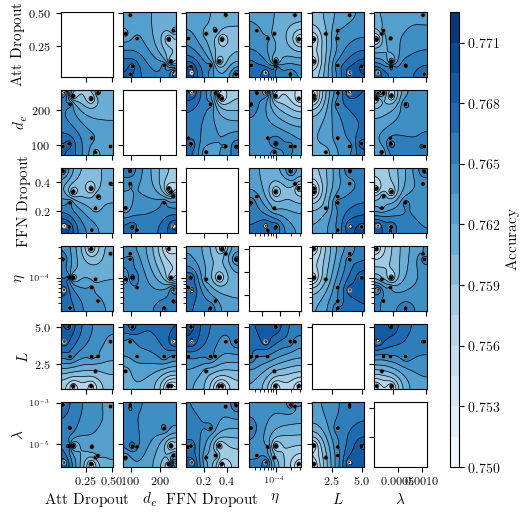

In [40]:
axes = plot_contour(study)
plt.savefig(f"../reports/Graphs/{study_id}-hyperparam-search-space.pdf", bbox_inches="tight")

## Training and Validation Loss of GBM

In [ ]:
run = wandb.init(project="thesis", entity="fbv")

model = "3laathab_CatBoostClassifier_default.cbm:v7"

model_name = model.split("/")[-1].split(":")[0]
study_id = model_name.split("_")[0]

artifact = run.use_artifact(model)
model_dir = artifact.download()

In [ ]:
# visualize learning curves
with open(Path(model_dir,model_name[:-4]+"_training.json"), 'r') as j:
     contents = json.loads(j.read())
    
# extract relevant keys
iterations = contents.get("iterations")
test_metrics = [d['name'] for d in contents['meta']['test_metrics'] ]
test_results = [d['test'] for d in iterations]
learn_metrics = [d['name'] for d in contents['meta']['learn_metrics'] ]
learn_results = [d['learn'] for d in iterations]

metrics_learn = pd.DataFrame(learn_results, columns=learn_metrics).add_suffix(" (train)")
metrics_test = pd.DataFrame(test_results, columns=test_metrics).add_suffix(" (val)")

learning_metrics = pd.concat([metrics_learn, metrics_test], axis=1)

In [ ]:
# viz transformer
run = wandb.init(project="thesis", entity="fbv")

model = "fbv/thesis/viz_fttransformer:latest"

from google.colab import auth
auth.authenticate_user()

artifact = run.use_artifact(model)
model_dir = artifact.download()

learning_metrics = pd.read_parquet(Path(model_dir, "results"))

In [ ]:
fig, (ax2, ax4, ax3, ax1) = plt.subplots(4, 1, figsize=(12*CM, 15*CM))

loss_train = learning_metrics[["default_train_loss", "activation_train_loss", "lr_scheduler_train_loss", "sample_weighting_train_loss", "label_smoothing_train_loss"]].dropna(how="any").reset_index(drop=True).rolling(20).mean()

ax2.plot(loss_train.index,loss_train["default_train_loss"], label="Default", linewidth=1, zorder=100)
ax2.plot(loss_train.index,loss_train["activation_train_loss"], label="Activation", linewidth=1)
ax2.plot(loss_train.index,loss_train["label_smoothing_train_loss"], label="Label Smoothing", linewidth=1)
ax2.plot(loss_train.index,loss_train["lr_scheduler_train_loss"], label="Lr Schedule", linewidth=1)
ax2.plot(loss_train.index,loss_train["sample_weighting_train_loss"], label="Sample Weighting", linewidth=1)
ax2.set_ylabel("Log Loss (Train)")

ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
# ax2.set_xlabel("Iteration")

n_epochs = 10

step_size = int(max(learning_metrics["default_train_step"]) / n_epochs)

for i in range(step_size, step_size * n_epochs + 1, step_size):
    ax2.axvline(x=i, linestyle='--', color='grey', linewidth=0.5)

ax2.set_xlim(0, step_size * n_epochs - 1)


#

acc_train = learning_metrics[["default_train_accuracy", "activation_train_accuracy", "lr_scheduler_train_accuracy", "sample_weighting_train_accuracy", "label_smoothing_train_accuracy"]].dropna(how="any").reset_index(drop=True).rolling(20).mean()
ax4.plot(acc_train.index, acc_train["default_train_accuracy"], label="Default", linewidth=1, zorder=100)
ax4.plot(acc_train.index, acc_train["activation_train_accuracy"], label="Activation", linewidth=1)
ax4.plot(acc_train.index, acc_train["label_smoothing_train_accuracy"], label="Label Smoothing", linewidth=1)
ax4.plot(acc_train.index, acc_train["lr_scheduler_train_accuracy"], label="Lr Schedule", linewidth=1)
ax4.plot(acc_train.index, acc_train["sample_weighting_train_accuracy"], label="Sample Weighting", linewidth=1)

n_epochs = 10

step_size = int(len(acc_train) / n_epochs)

for i in range(step_size, step_size * n_epochs + 1, step_size):
    ax4.axvline(x=i, linestyle='--', color='grey', linewidth=0.5)

ax4.set_xlim(0, step_size * n_epochs - 1)
ax4.set_ylim(0.67, 0.80)


ax4.set_ylabel("Accuracy (Train)")
ax4.set_xlabel("Iteration")
ax4.yaxis.set_major_formatter(PercentFormatter(1.0,decimals=2))
ax4.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

loss_val = learning_metrics.groupby("default_epoch")[["default_val_loss", "activation_val_loss", "lr_scheduler_val_loss", "sample_weighting_val_loss", "label_smoothing_val_loss"]].mean()


ax3.plot(loss_val.index,loss_val["default_val_loss"], label="Default", linewidth=1, zorder=100)
ax3.plot(loss_val.index,loss_val["activation_val_loss"], label="Activation", linewidth=1)
ax3.plot(loss_val.index,loss_val["label_smoothing_val_loss"], label="Label Smoothing", linewidth=1)
ax3.plot(loss_val.index,loss_val["lr_scheduler_val_loss"], label="Lr Schedule", linewidth=1)
ax3.plot(loss_val.index,loss_val["sample_weighting_val_loss"], label="Sample Weighting", linewidth=1)
ax3.set_ylabel("Log Loss (Val)")
# ax3.set_xlabel("Step")
n_epochs = 10

step_size = int(len(loss_val) / n_epochs)

for i in range(step_size, step_size * n_epochs + 1, step_size):
    ax3.axvline(x=i, linestyle='--', color='grey', linewidth=0.5)

# ax.set_ylim(0.6, 0.72)

# ax3.set_xlabel("Step")
ax3.set_ylabel("Log Loss (Val)")
ax3.set_xlim(0, step_size * n_epochs - 1)

ax3.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

acc_val = learning_metrics.groupby("default_epoch")[["default_val_accuracy", "activation_val_accuracy", "lr_scheduler_val_accuracy", "sample_weighting_val_accuracy", "label_smoothing_val_accuracy"]].mean()
ax1.plot(acc_val.index,acc_val["default_val_accuracy"], label="Default", linewidth=1, zorder=100)
ax1.plot(acc_val.index,acc_val["activation_val_accuracy"], label="Activation", linewidth=1)
ax1.plot(acc_val.index,acc_val["label_smoothing_val_accuracy"], label="Label Smoothing", linewidth=1)
ax1.plot(acc_val.index,acc_val["lr_scheduler_val_accuracy"], label="Lr Schedule", linewidth=1)
ax1.plot(acc_val.index,acc_val["sample_weighting_val_accuracy"], label="Sample Weighting", linewidth=1)
ax1.set_ylabel("Log Loss (Val)")
ax1.set_xlabel("Epoch")
n_epochs = 10

step_size = int(len(loss_val) / n_epochs)

for i in range(step_size, step_size * n_epochs + 1, step_size):
    ax1.axvline(x=i, linestyle='--', color='grey', linewidth=0.5)

ax1.set_xlim(0, step_size * n_epochs - 1)
# ax.set_ylim(0.6, 0.72)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy (Val)")
ax1.yaxis.set_major_formatter(PercentFormatter(1.0,decimals=2))
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', frameon=False, ncol=3, bbox_to_anchor = (0, -0.07, 1, 1))

plt.tight_layout()

plt.savefig(f"fttransformer-optimisations-loss-acc.pdf", bbox_inches="tight")

In [ ]:
# plot accuracy
ax1.plot(learning_metrics.index,learning_metrics["default_val_acc"],'--', label="default", linewidth=1, zorder=100)
ax1.plot(learning_metrics.index,learning_metrics["early_stopping_val_acc"],'--', label="early stopping", linewidth=1)
ax1.plot(learning_metrics.index,learning_metrics["grow_policy_val_acc"],'--', label="grow policy", linewidth=1)
ax1.plot(learning_metrics.index,learning_metrics["exp_weighting_val_acc"],'--', label="sample weighting", linewidth=1)

ax1.yaxis.set_major_formatter(PercentFormatter(1.0,decimals=2))
ax1.set_ylabel("Accuracy (Val)")
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1.set_ylim(0.57, 0.64)
ax1.set_xlabel("Iterations")

# plot log loss
ax2.plot(learning_metrics.index,learning_metrics["default_val_log"], label="default", linewidth=1, zorder=100)
ax2.plot(learning_metrics.index,learning_metrics["early_stopping_val_log"], label="early stopping", linewidth=1)
ax2.plot(learning_metrics.index,learning_metrics["grow_policy_val_log"], label="grow policy", linewidth=1)
ax2.plot(learning_metrics.index,learning_metrics["exp_weighting_val_log"], label="sample weighting", linewidth=1)
ax2.set_ylabel("Log Loss (Val)")
ax2.set_ylim(0.55, 0.7)

plt.tight_layout()
ax1.legend(frameon=False, loc='lower right')
ax2.legend(frameon=False, loc='lower right')

plt.savefig(f"../reports/Graphs/gbm-optimisations-loss-acc.pdf", bbox_inches="tight")

In [ ]:
# viz gradient boosting
run = wandb.init(project="thesis", entity="fbv")
model = "exp_weighting:latest"

from google.colab import auth
auth.authenticate_user()

artifact = run.use_artifact(model)
model_dir = artifact.download()

In [ ]:
learning_metrics = pd.read_parquet(Path(model_dir, "results"))
learning_metrics.head()

In [ ]:
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(12*CM,7.5*CM), sharex=True)

# plot accuracy
ax1.plot(learning_metrics.index,learning_metrics["default_learn_acc"], label="Train", linewidth=1)
ax1.plot(learning_metrics.index,learning_metrics["default_val_acc"], label="Val",linewidth=1)
ax1.yaxis.set_major_formatter(PercentFormatter(1.0,decimals=2))
ax1.set_ylabel("Accuracy")
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1.set_xlabel("Iterations")

# plot log loss
ax2.plot(learning_metrics.index,learning_metrics["default_learn_log"], label="Train",linewidth=1)    
ax2.plot(learning_metrics.index,learning_metrics["default_val_log"], label="Val",linewidth=1)   
ax2.set_ylabel("Log Loss")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', frameon=False, ncol=4, bbox_to_anchor = (0, -0.03, 1, 1))

plt.tight_layout()

plt.savefig("gbm-train-val-loss-acc.pdf", bbox_inches="tight")

In [ ]:
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(12*CM,7.5*CM), sharex=True)

# ["default", "depth", "early_stopping", "border_count", "grow_policy", "exp_weighting"]

# plot accuracy
ax1.plot(learning_metrics.index,learning_metrics["default_val_acc"], label="Default", linewidth=1, zorder=100)
ax1.plot(learning_metrics.index,learning_metrics["early_stopping_val_acc"], label="Early Stopping", linewidth=1)
ax1.plot(learning_metrics.index,learning_metrics["grow_policy_val_acc"], label="Grow Policy", linewidth=1)
ax1.plot(learning_metrics.index,learning_metrics["exp_weighting_val_acc"], label="Sample Weighting", linewidth=1)

ax1.yaxis.set_major_formatter(PercentFormatter(1.0,decimals=2))
ax1.set_ylabel("Accuracy (Val)")
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#ax1.set_ylim(0.57, 0.64)
ax1.set_xlabel("Iterations")

# plot log loss
ax2.plot(learning_metrics.index,learning_metrics["default_val_log"], label="Default", linewidth=1, zorder=100)
ax2.plot(learning_metrics.index,learning_metrics["early_stopping_val_log"], label="Early Stopping", linewidth=1)
ax2.plot(learning_metrics.index,learning_metrics["grow_policy_val_log"], label="Grow Policy", linewidth=1)
ax2.plot(learning_metrics.index,learning_metrics["exp_weighting_val_log"], label="Sample Weighting", linewidth=1)
ax2.set_ylabel("Log Loss (Val)")
# ax2.set_ylim(0.55, 0.7)

plt.tight_layout()

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', frameon=False, ncol=4, bbox_to_anchor = (0, -0.03, 1, 1))

plt.tight_layout()

plt.savefig(f"gbm-optimisations-loss-acc.pdf", bbox_inches="tight")

## Warm-up Cosine decay

In [ ]:
import numpy as np
from torch import optim
from torch import nn


class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor


In [ ]:
layer = nn.Linear(10, 1)

optimizer = optim.AdamW(
    layer.parameters(),
    lr=1e-3,
    weight_decay=0.01,
)

max_iters = 2**10
# saw recommendation of 5 - 10 % of total training budget or 100 to 500 steps
warmup = int(0.05 * max_iters)
print(f"warmup steps: {warmup}")
print(max_iters)


scheduler = CosineWarmupScheduler(
    optimizer=optimizer, warmup=warmup, max_iters=max_iters
)

In [ ]:
lr = 1e-3

factor = [scheduler.get_lr_factor(i) * lr  for i in range(0, max_iters)]

fig = plt.figure(figsize=(12 * CM, 3.5 * CM))

plt.plot(factor, linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")

plt.savefig(f"lr-lin-warmup-cosine-decay.pdf", bbox_inches="tight")

## Feature Importances

In [171]:
# TODO: replace with versioned results

fi_classical = pd.read_parquet(f"gs://thesis-bucket-option-trade-classification/data/results/ise_supervised_test_classical_feature_importance.parquet")
fi_gbm = pd.read_parquet(f"gs://thesis-bucket-option-trade-classification/data/results/ise_supervised_test_gbm_feature_importance.parquet")
fi_transformer = pd.read_parquet(f"gs://thesis-bucket-option-trade-classification/data/results/ise_supervised_test_fttransformer_feature_importance.parquet")

# set features to nan that are not part of dataset
fi_classical.loc[["size_ex (grouped)", "TRADE_SIZE"],["quote(best)->quote(ex) values","quote(best)->quote(ex) std"]] = np.NaN

In [172]:
fi = pd.concat([fi_classical, fi_gbm, fi_transformer], axis=1)

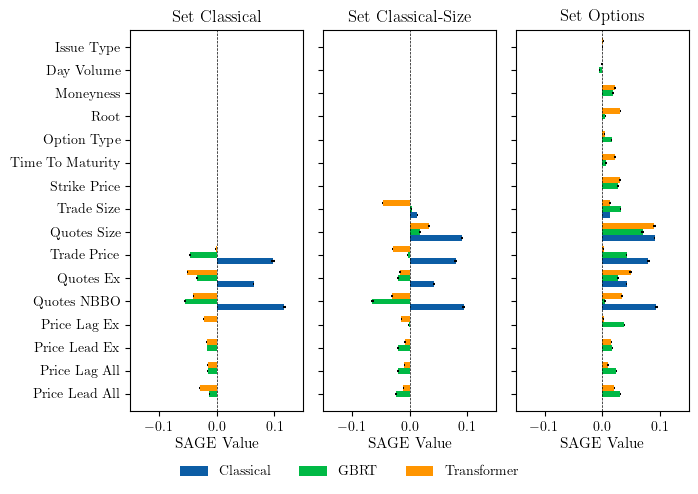

In [182]:
fig, axes = plt.subplots(1, 3, figsize=(18*CM, 12*CM), sharex=False, sharey=True)

# adapted from here: https://stackoverflow.com/a/15214551/5755604
ind = np.arange(len(fi))
width = 0.25

axes[0].barh(ind, fi["quote(best)->quote(ex) values"], width, xerr=fi["quote(best)->quote(ex) std"], label="Classical")
axes[0].barh(ind+width, fi["gbm(classical) values"], width, xerr=fi["gbm(classical) std"], label="GBRT")
axes[0].barh(ind+width + width, fi["fttransformer(classical) values"], width, xerr=fi["fttransformer(classical) std"], label="Transformer")
axes[0].axvline(0, color='black', linestyle='--', linewidth=0.5)
axes[0].set_xlim([-0.15,0.15])

axes[1].barh(ind, fi["trade_size(ex)->quote(best)->quote(ex)->depth(best)->depth(ex)->rev_tick(all) values"], width, xerr=fi["trade_size(ex)->quote(best)->quote(ex)->depth(best)->depth(ex)->rev_tick(all) std"], label="Classical")
axes[1].barh(ind+width, fi["gbm(classical-size) values"], width, xerr=fi["gbm(classical-size) std"], label="GBRT")
axes[1].barh(ind+width + width, fi["fttransformer(classical-size) values"], width, xerr=fi["fttransformer(classical-size) std"], label="Transformer")
axes[1].axvline(0, color='black', linestyle='--', linewidth=0.5)
axes[1].set_xlim([-0.15,0.15])

axes[2].barh(ind, fi["trade_size(ex)->quote(best)->quote(ex)->depth(best)->depth(ex)->rev_tick(all) values"], width, xerr=fi["trade_size(ex)->quote(best)->quote(ex)->depth(best)->depth(ex)->rev_tick(all) std"], label="Classical")
axes[2].barh(ind+width, fi["gbm(ml) values"], width, xerr=fi["gbm(ml) std"], label="GBRT")
axes[2].barh(ind+width + width, fi["fttransformer(ml) values"], width, xerr=fi["fttransformer(ml) std"], label="Transformer")
axes[2].axvline(0, color='black', linestyle='--', linewidth=0.5)
axes[2].set_xlim([-0.15,0.15])


# set y-labels
labels = ['Price Lead All', 'Price Lag All', 'Price Lead Ex', 'Price  Lag Ex', 'Quotes NBBO', 'Quotes Ex', 'Trade Price', "Quotes Size", 'Trade Size', 'Strike Price', 'Time To Maturity', 'Option Type', 'Root', 'Moneyness', "Day Volume", 'Issue Type']
axes[0].set(yticks=ind + width, yticklabels=labels, ylim=[2*width - 1, len(fi)])

# set x-labels
axes[0].set_xlabel("SAGE Value")
axes[1].set_xlabel("SAGE Value")
axes[2].set_xlabel("SAGE Value")

# set y-labels
axes[0].set_title("Set Classical")
axes[1].set_title("Set Classical-Size")
axes[2].set_title("Set Options")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = "lower center", frameon=False, bbox_to_anchor=(0.5, -0.05), ncols=3)

plt.tight_layout()

plt.savefig(f"../reports/Graphs/sage-importances.pdf", bbox_inches="tight")